PREPROCESSING

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import AUC, Recall, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import keras_tuner as kt

import os
import shutil
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image, ImageOps
import pandas as pd
import numpy as np
from numpy.random import seed
import random

# random.seed(24)
seed(24)
# tf.random.set_seed(24)


In [ ]:
dataDirectory = '/Users/jeremyelvander/AISC_BP_FQ24_MRI/brain_tumor_dataset'

#Open image, ensure grayscale, resize to specified size
def imageProcessor(filename, w, h, scaler = None):
    image = Image.open(filename)
    image = ImageOps.grayscale(image)
    image = image.resize((w, h), Image.LANCZOS) #Image.LANCZOS for high quality downsampling
    
    #Deprecated version, not working properly
    if scaler:  # Apply standard scaling if a scaler is passed
        image = np.array(image)
        image = scaler.transform(image.reshape(-1, 1).T).reshape(image.shape)
    else:
        image = np.array(image) / 255.0
    return image

#Load data
def dataLoad(directoryList):
    data = []
    labels = []

    #set image W/H, create scaler
    imageW, imageH = 150, 150
    scaler = StandardScaler()

    temp_data = []
    #Not used
    for dir in directoryList:
        for scan in listdir(dir):
            image = imageProcessor(dir + "/" + scan, imageW, imageH)
            temp_data.append(image)

    temp_data = np.array(temp_data).reshape(-1, imageW * imageH)  # Flatten for fitting the scaler
    scaler.fit(temp_data)  # Fit the scaler to the pixel data
    
    #Iterating through directories
    for dir in directoryList:
        #Iterating through each image
        for scan in listdir(dir):
            image = imageProcessor(dir + "/" + scan, imageW, imageH)#, scaler = scaler)
            data.append(image)

            #Adding labels
            if 'no' in dir:
                labels.append([0])
            else:
                labels.append([1])
    
    data = np.array(data)
    #Adding channel dimension
    data = data.reshape(data.shape[0], 150, 150, 1)
    labels = np.array(labels)
    return data, labels

def dataAugment(tuple):
    raise NotImplementedError


In [73]:
#Creating directories
directory = [dataDirectory + "/no", dataDirectory + "/yes"]

#Loading data and labels
data, labels = dataLoad(directory)


#Splititng into training and test sets
dataTrain, dataTest, labelsTrain, labelsTest = train_test_split(data, labels, 
                                                                test_size = 0.2, shuffle = True, stratify = labels, random_state = 24)

#Creating data augment variable
dataAugment = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,

    horizontal_flip=True,
    validation_split=0.2
)

#Augmenting training and validation data
trainData = dataAugment.flow(dataTrain, labelsTrain, batch_size=32, subset='training')
valData = dataAugment.flow(dataTrain, labelsTrain, batch_size=32, subset='validation')

#Creating function to build model
def modelBuilder(hp):

    #Defining sequential model
    model = models.Sequential()

    #Convolution layer - 32 neurons - 5x5 filter size - l2 regularization
    model.add(layers.Conv2D(32, (5, 5), activation='relu', data_format = 'channels_last',
                            input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(0.01)))
    #Pooling
    model.add(layers.MaxPooling2D((2, 2)))
    #Convolution layer - 64 neurons - 5x5 filter size - l2 regularization
    model.add(layers.Conv2D(64, (5, 5), activation='relu', data_format = 'channels_last',
                            kernel_regularizer=regularizers.l2(0.01)))
    #Pooling
    model.add(layers.MaxPooling2D((2, 2)))
    #Convolution layer - 128 neurons - 3x3 filter size - l2 regularization
    model.add(layers.Conv2D(128, (3, 3), activation='relu', data_format = 'channels_last',
                            kernel_regularizer=regularizers.l2(0.01)))
    #Pooling
    model.add(layers.MaxPooling2D((2, 2)))

    #Flattening layer
    model.add(layers.Flatten())

    #First dense layer - picking neurons from 32-512 with Keras Tuner
    model.add(layers.Dense(hp.Int('units', 
                                               min_value = 32, max_value = 512, 
                                               step = 32), activation='relu'))
    #Adding dropout layer - helps with overfitting and improves generalization
    model.add(layers.Dropout(0.6))
    #Final dense layer, sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    #Compiling with ADAM optimizer, choosing learning rate with Keras Tuner
    #Accuracy, AUC, and Recall for evaluation metrics
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(), Recall()])
    
    return model

#Constructing tuner, training epochs at 6, basing on validation  accuracy
#Saving to new directory in main directory
tuner = kt.Hyperband(
    modelBuilder,
    objective = 'val_accuracy',
    max_epochs = 6,
    factor = 3,
    directory = "/Users/jeremyelvander/Desktop/AISC/BPF24",
    project_name = "TuningLogs",
   overwrite = True
)

#Clearing keras session to avoid tuner overwrite issues
tf.keras.backend.clear_session()
#Manually setting tuner directory
tuning_directory = '/Users/jeremyelvander/Desktop/AISC/BPF24/TuningLogs'

# Delete the directory if it exists
if os.path.exists(tuning_directory):
    shutil.rmtree(tuning_directory)

#Creating callbacks for hyperparameter search
#Reducing learn rate - reduces learn rate when model stops improving, helps convergence efficiency
reduceLearnRate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
#Early stopping - monitors validation loss, stops training when models performance validation set starts to worsen
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)

#Use tuner to search for hyperparameters
tuner.search(trainData, validation_data = valData, epochs = 6, callbacks = [early_stop, reduceLearnRate])
bestHyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
#Get best model
bestModel = tuner.get_best_models(num_models = 1)[0]
#Rebuild model with hyperparameters
bestModel = modelBuilder(bestHyperparams)

Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.824999988079071

Best val_accuracy So Far: 0.824999988079071
Total elapsed time: 00h 01m 12s


In [74]:

history = bestModel.fit(trainData, epochs=30, batch_size=32, validation_data=valData, callbacks=[early_stop, reduceLearnRate])

#Recompile if necessary
# bestModel.compile(optimizer=bestModel.optimizer,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy', AUC(), Recall()])


testData = ImageDataGenerator().flow(dataTest, labelsTest, batch_size=32)
test_loss, test_accuracy, test_auc, test_recall = bestModel.evaluate(testData, verbose=1)

# Print out the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/30
6/6 [==============================] - 2s 327ms/step - loss: 1.8305 - accuracy: 0.6173 - auc_1: 0.6391 - recall_1: 0.6800 - val_loss: 1.6091 - val_accuracy: 0.6250 - val_auc_1: 0.8047 - val_recall_1: 0.9583 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 2s 309ms/step - loss: 1.5285 - accuracy: 0.7037 - auc_1: 0.7252 - recall_1: 0.8700 - val_loss: 1.3689 - val_accuracy: 0.8250 - val_auc_1: 0.7812 - val_recall_1: 0.9583 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 2s 357ms/step - loss: 1.2792 - accuracy: 0.7346 - auc_1: 0.7902 - recall_1: 0.9200 - val_loss: 1.1545 - val_accuracy: 0.8500 - val_auc_1: 0.8125 - val_recall_1: 0.8750 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 2s 292ms/step - loss: 1.1508 - accuracy: 0.7222 - auc_1: 0.7803 - recall_1: 0.7700 - val_loss: 1.0692 - val_accuracy: 0.8000 - val_auc_1: 0.7878 - val_recall_1: 0.9583 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 2s 348ms/step - loss: 1.06

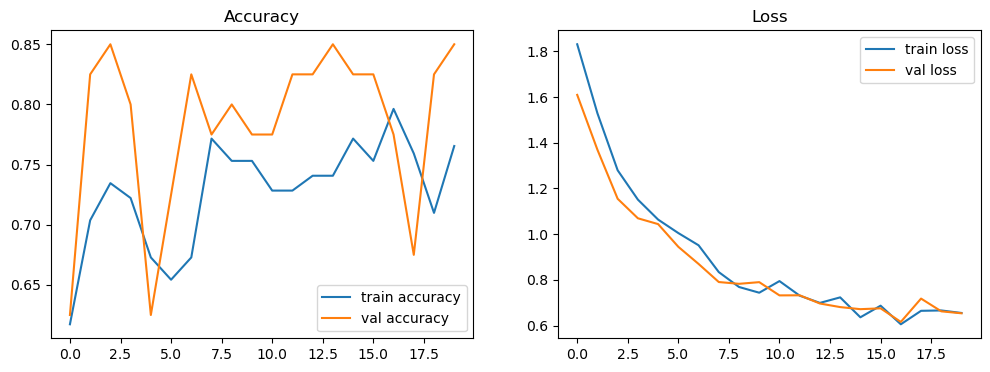

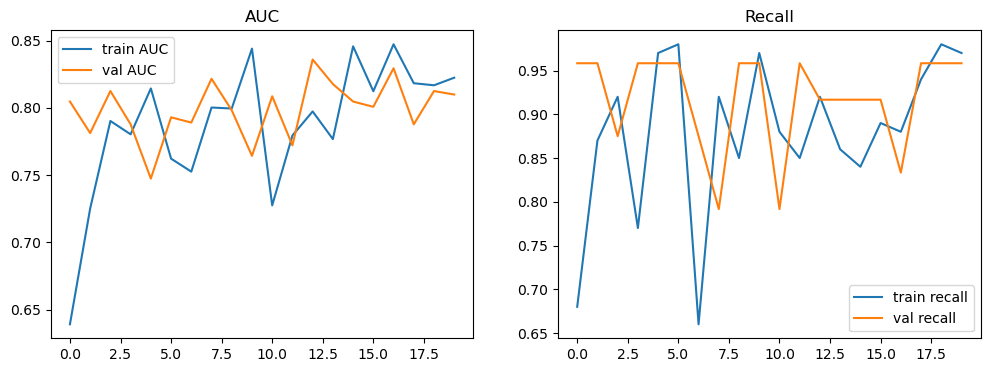

In [75]:
import matplotlib.pyplot as plt

# Plot the training & validation loss and metrics (AUC, Recall)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

# Similarly, for AUC and Recall
plt.figure(figsize=(12, 4))

# Plot training & validation AUC
plt.subplot(1, 2, 1)
plt.plot(history.history['auc_1'], label='train AUC')
plt.plot(history.history['val_auc_1'], label='val AUC')
plt.title('AUC')
plt.legend()

# Plot training & validation Recall
plt.subplot(1, 2, 2)
plt.plot(history.history['recall_1'], label='train recall')
plt.plot(history.history['val_recall_1'], label='val recall')
plt.title('Recall')
plt.legend()

plt.show()

In [57]:
import pprint

pprint.pprint(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_auc_1', 'val_recall_1', 'lr'])


DISREGARD:

In [31]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', data_format = 'channels_last',
                            input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', data_format = 'channels_last',))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', data_format = 'channels_last',))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(), Recall()])
    

directory = [dataDirectory + "/no", dataDirectory + "/yes"]
data, labels = dataLoad(directory)

dataTrain, dataTest, labelsTrain, labelsTest = train_test_split(data, labels, 
                                                                test_size = 0.2, shuffle = True, stratify = labels, random_state = 24)

dataAugment = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    validation_split = 0.2
)
trainData = dataAugment.flow(dataTrain, labelsTrain, batch_size=32, subset='training')
valData = dataAugment.flow(dataTrain, labelsTrain, batch_size=32, subset='validation')


history = model.fit(trainData, epochs=30, batch_size=32, validation_data=valData)

testData = ImageDataGenerator().flow(dataTest, labelsTest, batch_size=32)
test_loss, test_accuracy, test_auc, test_recall = model.evaluate(testData, verbose=1)

# Print out the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/30
6/6 [==============================] - 1s 192ms/step - loss: 0.7687 - accuracy: 0.6173 - auc_1: 0.5882 - recall_1: 0.9600 - val_loss: 0.6516 - val_accuracy: 0.6000 - val_auc_1: 0.7018 - val_recall_1: 1.0000
Epoch 2/30
6/6 [==============================] - 1s 164ms/step - loss: 0.6203 - accuracy: 0.6173 - auc_1: 0.7385 - recall_1: 1.0000 - val_loss: 0.6680 - val_accuracy: 0.6000 - val_auc_1: 0.7552 - val_recall_1: 1.0000
Epoch 3/30
6/6 [==============================] - 1s 165ms/step - loss: 0.6304 - accuracy: 0.6173 - auc_1: 0.7689 - recall_1: 1.0000 - val_loss: 0.6178 - val_accuracy: 0.6000 - val_auc_1: 0.7695 - val_recall_1: 1.0000
Epoch 4/30
6/6 [==============================] - 1s 199ms/step - loss: 0.5927 - accuracy: 0.6790 - auc_1: 0.7731 - recall_1: 1.0000 - val_loss: 0.6229 - val_accuracy: 0.6000 - val_auc_1: 0.7839 - val_recall_1: 0.4583
Epoch 5/30
6/6 [==============================] - 1s 164ms/step - loss: 0.5975 - accuracy: 0.6667 - auc_1: 0.7256 - recall_1: 0.

In [33]:
import pprint

pprint.pprint(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_auc_1', 'val_recall_1'])


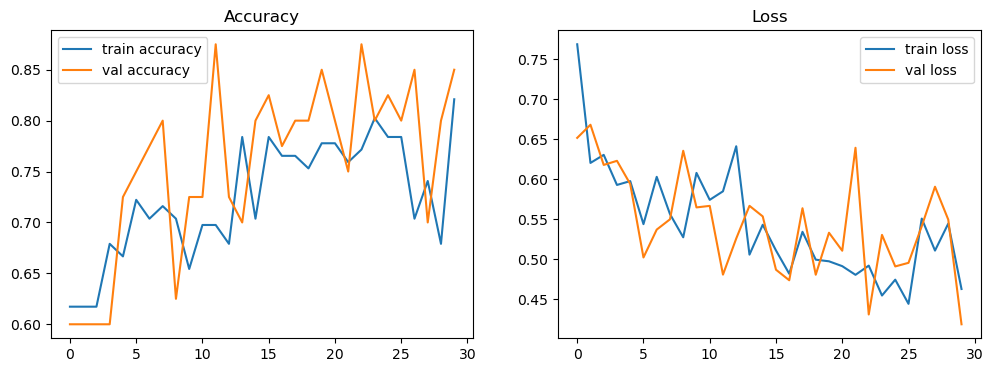

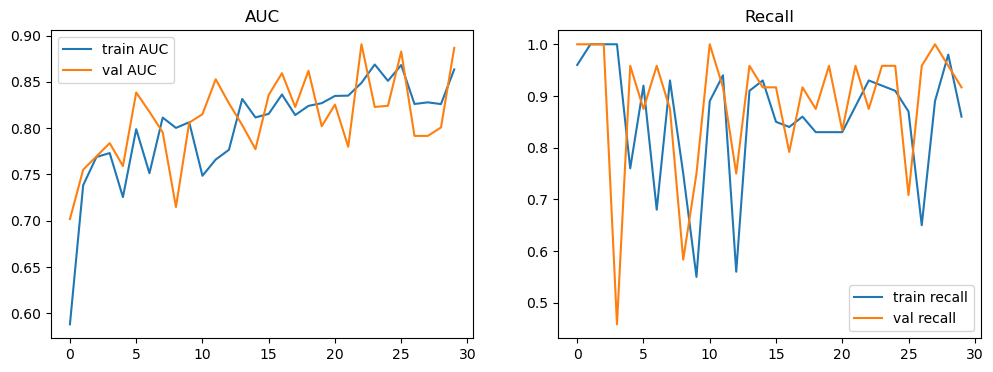

In [34]:
import matplotlib.pyplot as plt

# Plot the training & validation loss and metrics (AUC, Recall)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

# Similarly, for AUC and Recall
plt.figure(figsize=(12, 4))

# Plot training & validation AUC
plt.subplot(1, 2, 1)
plt.plot(history.history['auc_1'], label='train AUC')
plt.plot(history.history['val_auc_1'], label='val AUC')
plt.title('AUC')
plt.legend()

# Plot training & validation Recall
plt.subplot(1, 2, 2)
plt.plot(history.history['recall_1'], label='train recall')
plt.plot(history.history['val_recall_1'], label='val recall')
plt.title('Recall')
plt.legend()

plt.show()

array([[[[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]],

        [[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]],

        [[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]],

        ...,

        [[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]],

        [[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]],

        [[0.0627451 ],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [0.0627451 ],
         [0.0627451 ],
         [0.0627451 ]]],


       [[[0.02352941],
         [0.02352941],
         [0.02

(253, 150, 150, 1)


MODEL CREATION

Data splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
class_weights = {0: 1., 1: 50.}  # Example: Increase weight for 'tumor' class
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), class_weight=class_weights)